# CURTAINs

<img src="../Curtains.png" alt="Drawing" style="width: 300px;" align="left"/>

<br>
<p>
Welcome to the CURTAINs project, all windows need curtains.

Using sidebands to extrapolate to the signal region in a sliding window anomaly detection hunt.
</p>

# Having a look at our test dataset

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
jets = pd.read_hdf('/srv/beegfs/scratch/groups/dpnc/atlas/AnomalousJets/final_jj_1MEvents_substructure.h5','jets')

In [3]:
jets.head()

,pt,e,m,ecf1s,ecf2s,ecf3s,d12s,d23s,d34s,Qws,...,mass_q0,mass_q1,mass_q2,mass_q3,mass_q4,mass_q5,mass_q6,mass_q7,mass_q8,mass_q9
0,539.563283,785.799091,2.178882,540.615982,13192.470444,53004.584528,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,727.789084,1971.621355,9.359083,728.316547,32168.525905,754076.754048,19.885422,19.885422,19.885422,46.323833,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,472.478786,1079.801245,7.483273,462.230606,14131.220805,85619.972493,21.625550,21.625550,21.625550,21.137170,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,526.524344,552.349289,18.816513,432.847337,11500.202032,37097.462550,7.862928,7.862928,7.862928,12.178684,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1612.458173,1607.484065,13.926918,1591.640171,48563.815813,364979.595354,7.840845,7.840845,7.840845,15.623790,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Drop events with nan, these have <3 constituents which renders tau3 nonsensical (how can you split a jet into three prongs)

In [4]:
jets = jets.dropna()

In [5]:
jets.columns

Index(['pt', 'e', 'm', 'ecf1s', 'ecf2s', 'ecf3s', 'd12s', 'd23s', 'd34s',
       'Qws', 'taus', 'tau2s', 'tau3s', 'mass_q0', 'mass_q1', 'mass_q2',
       'mass_q3', 'mass_q4', 'mass_q5', 'mass_q6', 'mass_q7', 'mass_q8',
       'mass_q9'],
      dtype='object')

These quantiles were calculated over all jets and their mass, it was split into ten ~equal bins of 10k.

We can see that after removing nan events we lose a chunk from the first bin (no prob) and then they fluctuate a bit, but it's still roughly a 10% share of jets in each mass bin

In [6]:
quantiles = ['mass_q{}'.format(i) for i in range (10)]

In [7]:
jets[quantiles].mean()

mass_q0    0.074220
mass_q1    0.102499
mass_q2    0.102386
mass_q3    0.101120
mass_q4    0.102715
mass_q5    0.102931
mass_q6    0.103682
mass_q7    0.102550
mass_q8    0.103280
mass_q9    0.104618
dtype: float64

Looking at the distributions for the mass quantiles.

Again, for the actual use case we would look in narrower windows and not based on event fractions but we're playing with low statistics here.

In data we will deal with O(1e7) events at least

In [8]:
import matplotlib.cm as cm

In [9]:
cmap = cm.get_cmap('plasma')


In [27]:
m_vals,_=np.histogram(jets.m,weights=jets[q].values/np.sum(jets[q].values),bins=m_bins)

ValueError: too many values to unpack (expected 2)

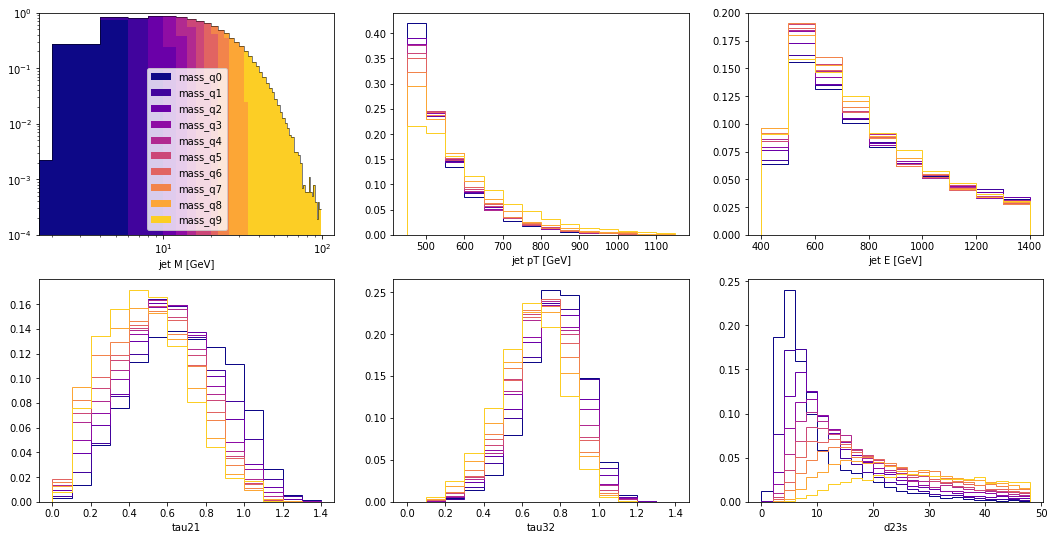

In [67]:
fig,axes=plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18,9)
m_bins = np.arange(0,100,2)
m_summed = np.zeros(len(m_bins)-1)
for i,q in enumerate(quantiles):
    m_vals,_=np.histogram(jets.m,weights=jets[q].values/np.sum(jets[q].values),bins=m_bins)
#     m_vals,_=np.histogram(jets.m,weights=jets[q].values,bins=m_bins)
    axes[0][0].bar((m_bins[1:]+m_bins[:-1])/2,m_vals,(m_bins[1:]-m_bins[:-1]),label=q,color=cmap(i/10.),bottom=m_summed)
    m_summed += m_vals
    axes[0][1].hist(jets.pt,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(450,1200,50),histtype='step',color=cmap(i/10.))
    axes[0][2].hist(jets.e,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(400,1500,100),histtype='step',color=cmap(i/10.))

    
    axes[1][0].hist(jets.tau2s/jets.taus,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,1.5,0.1),histtype='step',color=cmap(i/10.))
    axes[1][1].hist(jets.tau3s/jets.tau2s,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,1.5,0.1),histtype='step',color=cmap(i/10.))
    axes[1][2].hist(jets.d23s,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,50,2),histtype='step',color=cmap(i/10.))

axes[0][0].step(m_bins, np.insert(m_summed,0,m_summed[0]), 'k', linestyle='-',lw=0.5,where='pre')
axes[0][1].set_xlabel('jet pT [GeV]')
axes[0][2].set_xlabel('jet E [GeV]')
axes[0][0].set_xlabel('jet M [GeV]')
axes[0][0].semilogy()
axes[0][0].semilogx()
axes[0][0].set_ylim(0.0001,1.0)
axes[1][0].set_xlabel('tau21')
axes[1][1].set_xlabel('tau32')
axes[1][2].set_xlabel('d23s')
axes[0][0].legend(loc='best')
for ax,ax2 in axes[0],axes[1]:
    ax.set_ylabel('Normalised Entries')
    ax2.set_ylabel('Normalised Entries')

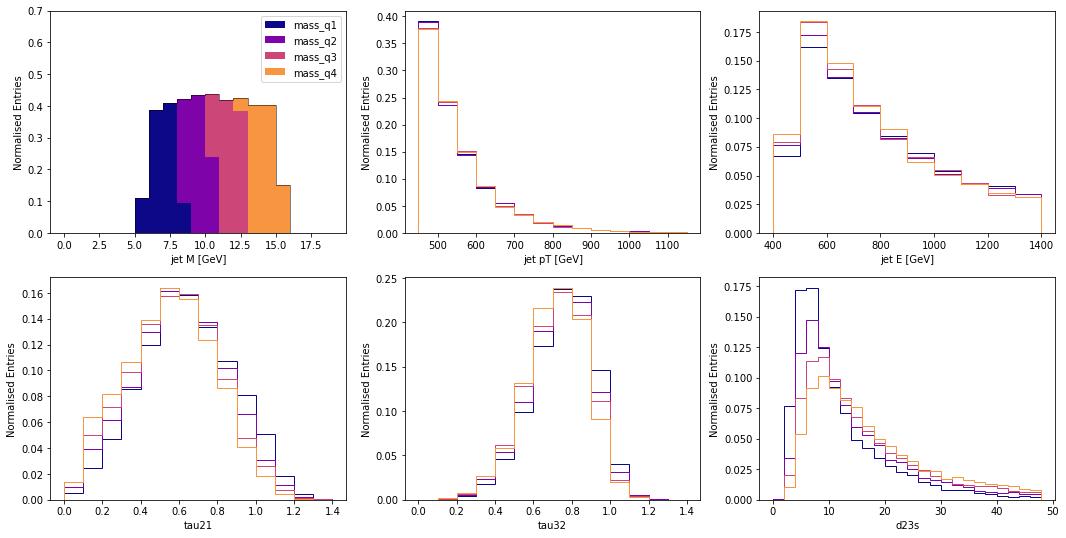

In [66]:
fig,axes=plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18,9)
m_bins = np.arange(0,20,1)
m_summed = np.zeros(len(m_bins)-1)
for i,q in enumerate(quantiles[1:5]):
    axes[0][1].hist(jets.pt,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(450,1200,50),histtype='step',color=cmap(i/4.))
    axes[0][2].hist(jets.e,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(400,1500,100),histtype='step',color=cmap(i/4.))
    m_vals,_=np.histogram(jets.m,weights=jets[q].values/np.sum(jets[q].values),bins=m_bins)
#     m_vals,_=np.histogram(jets.m,weights=jets[q].values,bins=m_bins)
    axes[0][0].bar((m_bins[1:]+m_bins[:-1])/2,m_vals,(m_bins[1:]-m_bins[:-1]),label=q,color=cmap(i/4.),bottom=m_summed)
    m_summed += m_vals
    axes[1][0].hist(jets.tau2s/jets.taus,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,1.5,0.1),histtype='step',color=cmap(i/4.))
    axes[1][1].hist(jets.tau3s/jets.tau2s,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,1.5,0.1),histtype='step',color=cmap(i/4.))
    axes[1][2].hist(jets.d23s,weights=jets[q].values/np.sum(jets[q].values),label=q,bins=np.arange(0,50,2),histtype='step',color=cmap(i/4.))

axes[0][0].step(m_bins, np.insert(m_summed,0,m_summed[0]), 'k', linestyle='-',lw=0.5,where='pre')
axes[0][0].set_ylim(0,0.7)
axes[0][1].set_xlabel('jet pT [GeV]')
axes[0][2].set_xlabel('jet E [GeV]')
axes[0][0].set_xlabel('jet M [GeV]')

axes[1][0].set_xlabel('tau21')
axes[1][1].set_xlabel('tau32')
axes[1][2].set_xlabel('d23s')
axes[0][0].legend(loc='best')
for ax,ax2 in axes[0],axes[1]:
    ax.set_ylabel('Normalised Entries')
    ax2.set_ylabel('Normalised Entries')
# axes[0][0].set_ylabel('Normalised Entries')
# axes[1][0].set_ylabel('Normalised Entries')

In the above case we would probably look for windows of around 10 GeV in width, but again, we want a proof of principle on small statistics that at least training the network is doable.

Focusing on tau32 and tau21 for now, we can also add d23s in there.

We will want to split into train/val datasets. When it comes to the network because our final application will not even include SB1<->SB2 but SB1->SR<-SB2 we will be able to reuse all the data used for training in evaluation and in validation in other windows (wider side band regions).

In [63]:
jets['tau32'] = jets.tau3s / jets.tau2s
jets['tau21'] = jets.tau2s / jets.taus

In [80]:
jets[jets[quantiles[2]]==1]

,pt,e,m,ecf1s,ecf2s,ecf3s,d12s,d23s,d34s,Qws,...,mass_q2,mass_q3,mass_q4,mass_q5,mass_q6,mass_q7,mass_q8,mass_q9,tau32,tau21
1,727.789084,1971.621355,9.359083,728.316547,32168.525905,7.540768e+05,19.885422,19.885422,19.885422,46.323833,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.518195,0.970901
10,596.320958,2182.675336,9.642057,596.243047,48930.457778,1.958466e+06,20.008653,20.008653,20.008653,27.363102,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.596696,0.724412
18,661.649491,1313.188101,10.295186,648.328468,48349.552670,9.334252e+05,35.086238,35.086238,35.086238,7.551988,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.896951,0.123140
20,716.872373,1419.275974,9.716273,696.151632,17831.074814,6.084322e+04,10.650966,10.650966,10.650966,10.936983,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.842464,0.462513
35,684.090264,1200.031895,9.996038,675.842294,21589.925306,2.343113e+05,10.113572,10.113572,10.113572,7.046226,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.657419,0.523596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99966,480.295481,4248.000759,10.393205,470.889930,36581.730674,7.125497e+05,30.889057,30.889057,30.889057,34.195603,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.510512,0.478375
99973,507.955810,750.491465,8.928312,498.439040,14766.675893,3.056496e+04,14.785690,14.785690,14.785690,13.317198,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.886931,0.443991
99980,465.352380,466.153055,9.893534,449.801592,10447.526358,1.101039e+05,6.569319,6.569319,6.569319,25.413155,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.733879,0.975089
99990,459.333345,1856.859188,9.831937,438.603879,17007.832142,1.071197e+05,16.558521,16.558521,16.558521,20.221185,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891869,0.501103


Just taking two quantiles for now, 2 and 4, assuming quantile 3 is now our signal region.
We have very few events to play with so we can't have a very expressionful network, but the transformation should be minor.


But something we should check is: if we are going to use an optimal transport loss to go from low mass -> high mass in a flow network, let's first check that our events of similar mass are "closer" to oneanother than they are to the target.

In [85]:
x_train = jets[jets[quantiles[2]]==1][['m','pt','e','tau32','tau21','d23s']]
y_train = jets[jets[quantiles[4]]==1][['m','pt','e','tau32','tau21','d23s']]

x_train,x_test = x_train[:5000],x_train[5000:10000]
y_train,y_test = y_train[:5000],y_train[5000:10000]

# To Do

* Choose an optimal transport loss
    * Measure distances within the same quantiles (x_train and x_test), (y_train and y_test) and compare to the training pairings (x and y)
    * It should be differentiable!
    * Train on pointcloud (batch of x to batch of y)
    * Learns based on distributions
* Could we also do an A to B map where now we aren't looking at point clouds but one to one mapping
    * Shuffle all events together from side bands at each epoch and pair x_test+y_test shuffled into lowermass_test and highermass_test
        * Definitely makes the SR an interpolation region and not soft extrapolation as minimum mass shift will be to transform an event to a mass point still within the same sideband
        * Or keep the x<->y setup and define the "closest" point in the target as the target
        * Or keep x<->y setup and randomly choose one of the target events as the target on each pass
    * Each epoch is shuffled so seeing all possible points, the minimum would be to learn f(x|m)
    * Learns based on individual transformations instead of learning over distributions
* Choose an architecture
    * Invertible Flows are our best choice
        * N to N mapping: we should maintain correlations here as the transformation should be a small displacement
        * Bidirectional: we have the same network for each side bands, this reduces our validation required and source of issues. The signal region will be an interpolation region
        * Conditional INN possible: we can use the initial and target mass as the conditions (plus jet pT perhaps)
            * Optimising the condition is key: we want to keep the signal window as an interpolation task for the flow model rather than be extrapolation:
                * If we use m1 and m2 then m1 will be in SB1 and m2 will be in SB2, no SR masses will ever be seen
                * m2 - m1 will always be bigger than m2 - mSR and mSR - m1
* Get some simple tests done
    * We can focus on a single directional flow to start with, can we conditionally transform an event to what it would have looked like at another mass point?
    * We can use the SR as validation for all these studies, as well as additional mass quantiles
    
Another point to consider is that if we use optimal transport, each "dimension" is not necessarily equivalent. tau32 looks different to d23s. Would we want to have an INN to "project" events onto a manifold, we do the transformation here, and then transform back with the inverse of the network. I think this is overcomplicating things.

# Name

The project needs a good name, and I will try to make CURTAINs work, because all windows need curtains, even signal windows and sliding windows.